In [8]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

sys.path.append('../')

from utils import load_atp_data

In [76]:
def kelly_winner_bet(row):
    
    base = row['model_w_pred']
    sub = (1 - base) / (row['psw'] - 1)
    
    return base - sub

def kelly_loser_bet(row):
    
    base = row['model_l_pred']
    sub = (1 - base) / (row['psl'] - 1)
    
    return base -sub

In [11]:
# loading all atp data
df = load_atp_data('../tennis_atp')

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [13]:
# loading the data with model predictions
oof_df = pd.read_csv("../data/prediction_df.csv", parse_dates=['player_tourney_date'])

In [5]:
# loading the betting data 
years = ['2021.xlsx', '2022.xlsx', '2023.xlsx']

folder = '../tennis_betting_data/'

betting_df = pd.DataFrame()

for year in years:
    df_ = pd.read_excel(f'{folder}{year}')
    betting_df = pd.concat([betting_df, df_])
    
betting_df['date_monday'] = betting_df['Date'] - pd.offsets.Week(weekday=0)
betting_df['winner_last_name'] = [x.split()[0] for x in betting_df.Winner]
betting_df['loser_last_name'] = [x.split()[0] for x in betting_df.Loser]

betting_df.drop(columns='Surface', inplace=True)

In [14]:
# creating a list->tuple of the players in each match
# we'll use these tuples to merge the dataframes 
# this shouldnt be necessary but i foolishly messed up the
# indices in the model df
unique_match_players = df[['winner_id', 'loser_id']].values.tolist()
df['details'] = unique_match_players
df['details'] = [tuple(sorted(x)) for x in df['details']]

unique_match_players_oof = oof_df[['player_id', 'player_2_id']].values.tolist()
oof_df['details'] = unique_match_players_oof
oof_df['details'] = [tuple(sorted(x)) for x in oof_df['details']]

# creating the assessment df by merging the two
assess_df = (
    oof_df
    .merge(df, how='left', left_on=['player_tourney_date', 'details'],
           right_on=['tourney_date', 'details'])
)

# indicating when player_id in oof_df matches winner
assess_df['player_one_winner'] = np.where(assess_df['player_id'] == assess_df['winner_id'], 1, 0)
assess_df['winner_last_name'] = [x.split()[-1] for x in assess_df.winner_name]
assess_df['loser_last_name'] = [x.split()[-1] for x in assess_df.loser_name]

In [82]:
# creating the trial dataframe to test our model

trial = assess_df.merge(betting_df, how='left', left_on=['tourney_date', 'winner_last_name', 'loser_last_name'],
                 right_on=['date_monday', 'winner_last_name', 'loser_last_name'])

trial = trial[~trial['date_monday'].isnull()]
trial.columns = trial.columns.str.lower()

# calculating odds with and without vigorish for the average price
trial['avg_vegas_pred_w'] = 1 / trial['avgw']
trial['avg_vegas_pred_l'] = 1 / trial['avgl']
trial['avg_overround'] = trial[['avg_vegas_pred_w', 'avg_vegas_pred_l']].sum(axis=1)
trial['avg_w_no_vig'] = trial['avg_vegas_pred_w'].div(trial['avg_overround'])
trial['avg_l_no_vig'] = trial['avg_vegas_pred_l'].div(trial['avg_overround'])

# calculating odds with and without vigorish for pinnacle
trial['pinnacle_vegas_pred_w'] = 1 / trial['psw']
trial['pinnacle_vegas_pred_l'] = 1 / trial['psl']
trial['pinnacle_overround'] = trial[['pinnacle_vegas_pred_w', 'pinnacle_vegas_pred_l']].sum(axis=1)
trial['pinnacle_w_no_vig'] = trial['pinnacle_vegas_pred_w'].div(trial['pinnacle_overround'])
trial['pinnacle_l_no_vig'] = trial['pinnacle_vegas_pred_l'].div(trial['pinnacle_overround'])

# converting the model predictions to winner and loser predictions
trial['model_w_pred'] = np.where(trial['player_one_winner'] == 1,
                                 trial['pred_player_one_win'],
                                 1 - trial['pred_player_one_win'])

trial['model_l_pred'] = 1 - trial['model_w_pred']

# calculating kelly bet given predictions
trial['winner_kelly_bet'] = trial.apply(kelly_winner_bet, axis=1)
trial['loser_kelly_bet'] = trial.apply(kelly_loser_bet, axis=1)

# dropping all rows where we don't have a vegas prediction
trial = trial[~trial['avg_vegas_pred_w'].isnull()].copy()
trial = trial[~trial['pinnacle_vegas_pred_w'].isnull()].copy()
trial = trial[trial['pinnacle_vegas_pred_w'].between(0, 1)].copy()
trial = trial[trial['avg_overround'].between(1, 1.07)].copy()
trial = trial[trial['pinnacle_overround'].between(1, 1.03)].copy()

print(trial.shape)

(3226, 194)


In [83]:
trial['rearrange'] = np.random.choice([0, 1], size=len(trial))
trial['p1'] = np.where(trial['rearrange'] == 1, trial['pinnacle_vegas_pred_w'], trial['pinnacle_vegas_pred_l'])
trial['p2'] = np.where(trial['rearrange'] == 1, trial['model_w_pred'], trial['model_l_pred'])
trial['p3'] = np.where(trial['rearrange'] == 1, trial['avg_vegas_pred_w'], trial['avg_vegas_pred_l'])

print("the logloss for pinnacle:", log_loss(trial['rearrange'], trial['p1']))
print("the logloss for my model:", log_loss(trial['rearrange'], trial['p2']))
print("the logloss for avg vegas:", log_loss(trial['rearrange'], trial['p3']))

the logloss for pinnacle: 0.5748254634577388
the logloss for my model: 0.5824280598425258
the logloss for avg vegas: 0.5776862859841835


In [95]:
# lets try diff kelly cutoffs
cutoff = 0.3
condition = (trial['winner_kelly_bet'] >= cutoff) | (trial['loser_kelly_bet'] >= cutoff)

kelly_df = trial[condition].copy()

log_loss(kelly_df['rearrange'], kelly_df['p1'])

0.5957249690539913

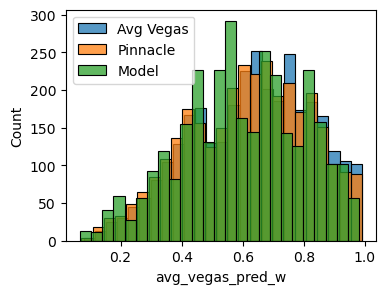

In [44]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['avg_vegas_pred_w'], bins=25, label='Avg Vegas')
sns.histplot(trial['pinnacle_vegas_pred_w'], bins=25, label='Pinnacle')
sns.histplot(trial['model_w_pred'], bins=25, label='Model')

plt.legend()
plt.show()

In [34]:
model_brier = lambda x: brier_score_loss(x['player_one_winner'], x['model_w_pred'])
pinnacle_vegas_brier = lambda x: brier_score_loss(x['player_one_winner'], x['pinnacle_vegas_pred_w'])

briers_df = (
    pd.concat([trial.groupby(['season', 'tourney_name']).apply(model_brier),
               trial.groupby(['season', 'tourney_name']).apply(pinnacle_vegas_brier)], axis=1)
    .rename(columns={0 : 'model', 1 : 'pinnacle'})
)

briers_df['model_wins'] = (briers_df['model'] < briers_df['pinnacle']).astype(int)

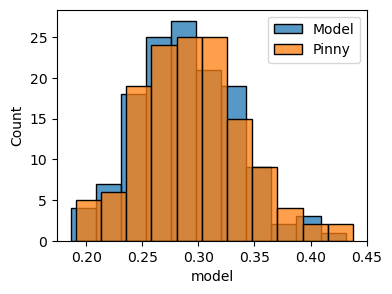

In [43]:
fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(briers_df['model'], label='Model')
sns.histplot(briers_df['pinnacle'], label='Pinny')

plt.legend()
plt.show()